In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.path import Path


In [11]:
def voronoi_finite_polygons_2d(vor, radius=1000):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    all_ridges = {}

    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_index in enumerate(vor.point_region):
        region = vor.regions[region_index]
        if -1 not in region:
            new_regions.append(region)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in region if v != -1]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_vertices.append(far_point.tolist())
            new_region.append(len(new_vertices) - 1)

        new_regions.append(new_region)

    return new_regions, np.array(new_vertices)

def sort_polygon(points):
    center = points.mean(axis=0)
    angles = np.arctan2(points[:,1] - center[1], points[:,0] - center[0])
    return points[np.argsort(angles)]


In [12]:
# ============================================================
# --- SIMULATION PARAMETERS ---
# ============================================================

WIDTH = 380
HEIGHT = 280
NUM_DISTRICTS = 8       # Number of districts
NUM_DOTS = 1000          # Number of voters
parties = 0
NUM_PARTIES = 4
cmap = plt.get_cmap('tab20')

COLORS = [cmap(i) for i in range(NUM_PARTIES)]
PARTY_IDS = [f"Party {i}" for i in range(NUM_PARTIES)]

# Dictionary mapping party name → color
PARTY_COLORS = dict(zip(PARTY_IDS, COLORS))

 # Parties (for efficiency gap and PR)
NUM_RUNS = 1000           # Number of simulations

# ============================================================
# --- CREATE FIXED DISTRICT MAP (run once) ---
# ============================================================

points = np.random.rand(NUM_DISTRICTS, 2)
points[:,0] *= WIDTH
points[:,1] *= HEIGHT
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)

# Store fixed district polygons
district_polygons = []
for region in regions:
    polygon = vertices[region]
    if len(polygon) < 3:
        district_polygons.append(None)
    else:
        district_polygons.append(sort_polygon(polygon))


In [13]:
def run_election():
    """
    Generates random voters and counts them per district.
    Returns:
        dots_x, dots_y, dots_party_ids, district_counts
    """
    dots_x = np.random.rand(NUM_DOTS) * WIDTH
    dots_y = np.random.rand(NUM_DOTS) * HEIGHT

    # Sample party IDs instead of colors
    party_array = np.array(PARTY_IDS, dtype=object)
    dots_party_ids = np.random.choice(party_array, NUM_DOTS)

    district_counts = []
    for polygon in district_polygons:
        counts = {party: 0 for party in PARTY_IDS}

        if polygon is None:
            district_counts.append(counts)
            continue

        poly_path = Path(polygon)
        mask = poly_path.contains_points(np.column_stack((dots_x, dots_y)))

        for party, inside in zip(dots_party_ids, mask):
            if inside:
                counts[party] += 1

        district_counts.append(counts)

    return dots_x, dots_y, dots_party_ids, district_counts


In [14]:
def efficiency_gc(district_counts):
    efficiency_gaps = []

    for index in range(len(district_counts)):
        district = district_counts[index]

        # Winning party
        winning_party = max(district.items(), key=lambda item: item[1])[0]
        num_winning_votes = district[winning_party]

        # Total votes in district
        num_votes_in_district = sum(district.values())

        # Losing votes
        num_losing_votes = num_votes_in_district - num_winning_votes

        # Wasted votes
        wasted_winner = num_winning_votes - (num_votes_in_district / NUM_PARTIES)
        wasted_loser = num_losing_votes

        # Efficiency gap for this district
        efficiency_gap = (wasted_winner - wasted_loser) / num_votes_in_district
        efficiency_gaps.append(efficiency_gap)

    return efficiency_gaps


In [15]:
def calculate_PR(district_counts):
    """
    Returns a dictionary of allocated seats per party using largest remainder method.
    """
    NUM_SEATS = NUM_DISTRICTS

    # Compute statewide votes
    statewide_votes = {party: 0 for party in PARTY_IDS}
    for district in district_counts:
        for party in PARTY_IDS:
            statewide_votes[party] += district[party]

    total_votes = sum(statewide_votes.values())
    exact_seats = {
        party: (statewide_votes[party] / total_votes) * NUM_SEATS
        for party in PARTY_IDS
    }

    # Assign integer seats first
    allocated_seats = {party: int(exact_seats[party]) for party in PARTY_IDS}
    remaining_seats = NUM_SEATS - sum(allocated_seats.values())

    # Largest remainder method
    remainders = {
        party: exact_seats[party] - allocated_seats[party]
        for party in PARTY_IDS
    }
    sorted_by_remainder = sorted(PARTY_IDS, key=lambda p: remainders[p], reverse=True)

    for i in range(remaining_seats):
        allocated_seats[sorted_by_remainder[i]] += 1

    return statewide_votes, allocated_seats


In [16]:
# ============================================================
# --- RUN SIMULATIONS ---
# ============================================================

all_results = []

for run in range(NUM_RUNS):
    dots_x, dots_y, dots_party_ids, district_counts = run_election()
    statewide_votes, allocated_seats = calculate_PR(district_counts)
    efficiency_gaps = efficiency_gc(district_counts)

    all_results.append({
        'statewide_votes': statewide_votes,
        'allocated_seats': allocated_seats,
        'dots_x': dots_x,
        'dots_y': dots_y,
        'dots_party_ids': dots_party_ids,
        'district_counts': district_counts,      # ← add this
        'efficiency_gaps': efficiency_gaps
    })


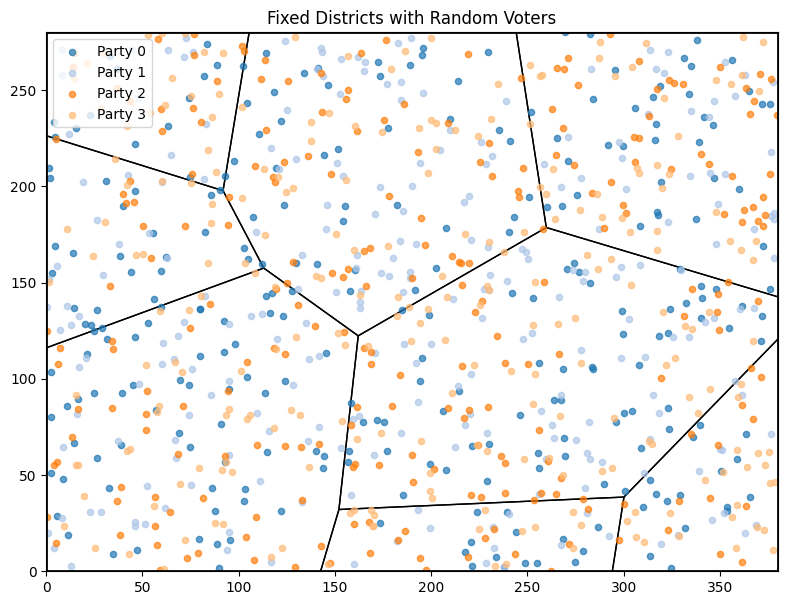

After loop, len(all_results) = 1000

--- Simulation 1 ---
Statewide votes: {'Party 0': 265, 'Party 1': 250, 'Party 2': 240, 'Party 3': 245}
Party 0 Vote/Total Vote: 0.265
Party 1 Vote/Total Vote: 0.25
Party 2 Vote/Total Vote: 0.24
Party 3 Vote/Total Vote: 0.245
District 1: {'Party 0': 15, 'Party 1': 12, 'Party 2': 16, 'Party 3': 16}
District 2: {'Party 0': 15, 'Party 1': 12, 'Party 2': 15, 'Party 3': 18}
District 3: {'Party 0': 23, 'Party 1': 15, 'Party 2': 11, 'Party 3': 14}
District 4: {'Party 0': 60, 'Party 1': 49, 'Party 2': 48, 'Party 3': 45}
District 5: {'Party 0': 59, 'Party 1': 62, 'Party 2': 46, 'Party 3': 52}
District 6: {'Party 0': 16, 'Party 1': 11, 'Party 2': 14, 'Party 3': 23}
District 7: {'Party 0': 40, 'Party 1': 56, 'Party 2': 47, 'Party 3': 41}
District 8: {'Party 0': 37, 'Party 1': 33, 'Party 2': 43, 'Party 3': 36}
Allocated seats: {'Party 0': 2, 'Party 1': 2, 'Party 2': 2, 'Party 3': 2}
Efficiency Gap: [-0.7076271186440678, -0.65, -0.5198412698412699, -0.65594059405

In [17]:
# ============================================================
# ---  visualize one run ---
# ============================================================

run_to_show = 0
dots_x = all_results[run_to_show]['dots_x']
dots_y = all_results[run_to_show]['dots_y']
dots_party_ids = all_results[run_to_show]['dots_party_ids']   # UPDATED

fig, ax = plt.subplots(figsize=(10,7))

# Draw district boundaries
for polygon in district_polygons:
    if polygon is not None:
        ax.fill(polygon[:,0], polygon[:,1], edgecolor='black', fill=False, linewidth=1)

# Plot voters by party
for party in PARTY_IDS:
    party_mask = (dots_party_ids == party)
    party_color = PARTY_COLORS[party]

    ax.scatter(
        dots_x[party_mask],
        dots_y[party_mask],
        c=[party_color],
        label=party,
        s=20,
        alpha=0.7
    )

# Draw bounding box
ax.plot([0, WIDTH, WIDTH, 0, 0], [0,0,HEIGHT,HEIGHT,0], color='black', linewidth=2)
ax.set_xlim(0, WIDTH)
ax.set_ylim(0, HEIGHT)
ax.set_aspect('equal')
ax.set_title('Fixed Districts with Random Voters')
ax.legend()
plt.show()
# ============================================================
# --- SHOW RESULTS ---
# ============================================================
print("After loop, len(all_results) =", len(all_results))

arr=[]
for i, result in enumerate(all_results[:1000]):
    print(f"\n--- Simulation {i+1} ---")
    
    statewide = result['statewide_votes']
    total_votes = sum(statewide.values())

    print("Statewide votes:", statewide)

    # Print each party's vote share
    for party, votes in statewide.items():
        print(f"{party} Vote/Total Vote:", votes / total_votes)

    # Print district counts for this run
    for d, counts in enumerate(result['district_counts']):
        print(f"District {d+1}: {counts}")

    print("Allocated seats:", result['allocated_seats'])
    print("Efficiency Gap:", result['efficiency_gaps'])

    gaps = result['efficiency_gaps']
    std_gap = np.std(gaps)
    print("Std Dev of Efficiency Gaps:", std_gap)

    arr.append(std_gap)



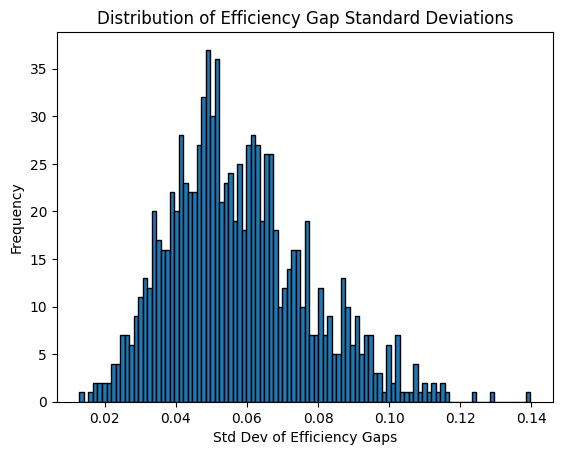

In [18]:
plt.hist(arr, bins=100, edgecolor='black')
plt.xlabel("Std Dev of Efficiency Gaps")
plt.ylabel("Frequency")
plt.title("Distribution of Efficiency Gap Standard Deviations")
plt.show()